**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
- 2. [Model class](#toc2_)    
  - 2.1. [Basic Edgeworth box](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
import matplotlib.pyplot as plt

# Use latex rendering for nice plot
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": "0.25",
    "grid.linestyle": "--",
    "font.size": 14,
})


%load_ext autoreload
%autoreload 2

import pandas as pd

import numpy as np
# Set seed number
np.random.seed(404)
from scipy import optimize

## 2. <a id='toc2_'></a>[Model class](#toc0_)

In [2]:
from ExchangeEconomy import ExchangeEconomyClass

### 2.1. <a id='toc2_1_'></a>[Basic Edgeworth box](#toc0_)

In [3]:
model = ExchangeEconomyClass()

1. Illustrating the set in a Edgeworth box

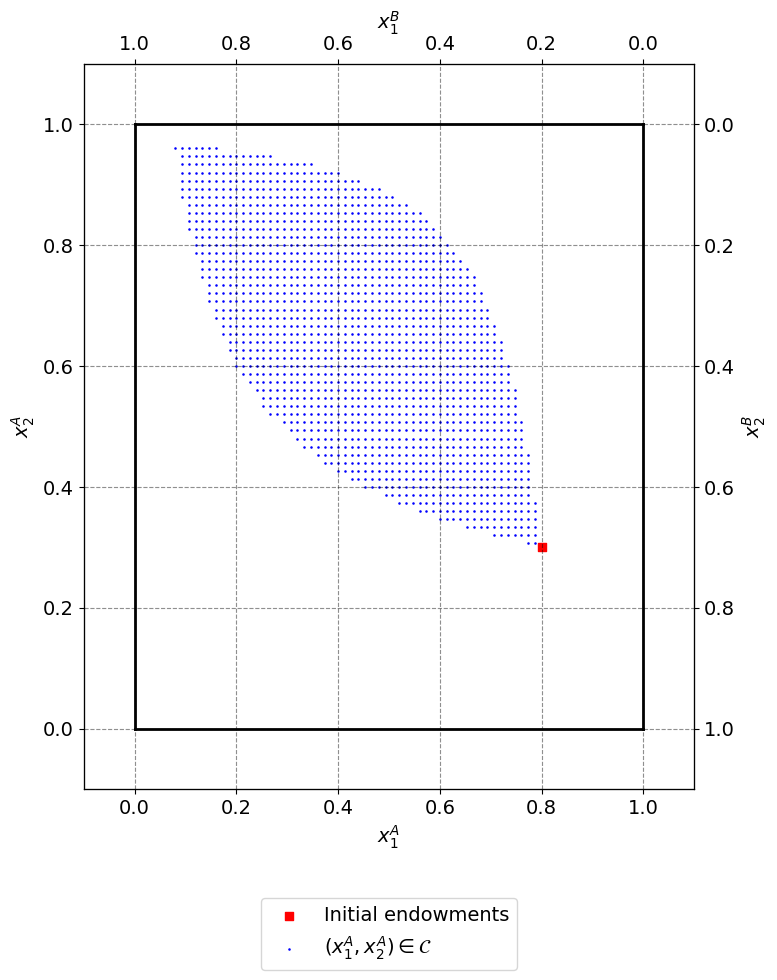

In [4]:

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig_A,ax_A = plt.subplots(figsize=(8,10),tight_layout=True)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(model.w1A,model.w2A,marker='s',color='r',label='Initial endowments')

# Initial endowments
omega_a1 = model.w1A
omega_a2 = model.w2A
omega_b1 = 1-model.w1A
omega_b2 = 1-model.w2A

# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

# Define the set C
C = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_A(xA1, xA2) >= model.utility_A(omega_a1, omega_a2) 
    and model.utility_B(1 - xA1, 1 - xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Plot C
ax_A.scatter([point[0] for point in C], [point[1] for point in C], marker='o', color='b', label=r'$(x_1^A, x_2^A) \in \mathcal{C}$', s=0.7)

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

legend = ax_A.legend(loc='center',bbox_to_anchor=(.5,-.2))

2. Calculate error in market clearing condition

In [5]:
P_1 = np.linspace(0.5,2.5,N+1)
eps_1,eps_2=model.market_clear_err(P_1)

# Use python-built in functions to find the minimum absolute error 
# Make sure they are the same across A/B (or very close to)
min_err1=abs(eps_1).min()
min_err2=abs(eps_2).min()
assert min_err1-min_err2<=1e-3

market_clearing_p=model.market_clear_price(P_1)

In [6]:
# Make larger linspace with smaller space to find (analytical) solution
P_1_analytical = np.linspace(0.5,2.5,20000)
market_clearing_p_analytical=model.market_clear_price(P_1_analytical)
eps_1_ana,eps_2_ana=model.market_clear_err(P_1_analytical)
min_err_analytical=abs(eps_1_ana).min()

Market clearing price p_1 in P_1 is 0.9533 with error 0.0053
"Analytical" market clearing price is 0.9444 with error 0.0


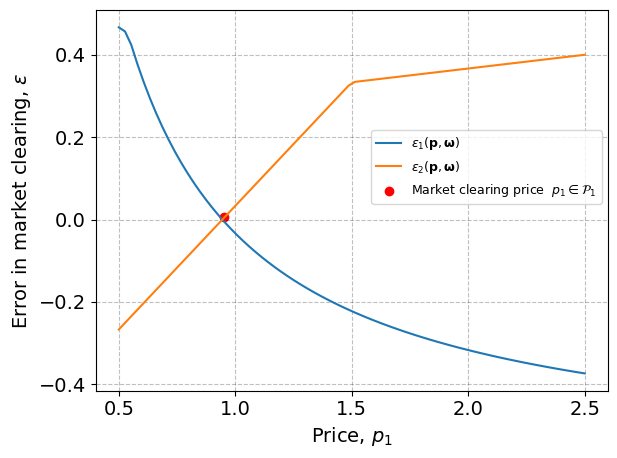

In [7]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(P_1, eps_1, label=r'$\epsilon_1(\mathbf{p}, \mathbf{\omega})$')
ax.plot(P_1, eps_2, label=r'$\epsilon_2(\mathbf{p}, \mathbf{\omega})$')
ax.scatter(market_clearing_p, min_err2, color='r', label=r'Market clearing price  $p_1 \in \mathcal{P}_1$')
ax.set_ylabel(r'Error in market clearing, $\epsilon$')
ax.set_xlabel(r'Price, $p_1$')
ax.legend(loc='upper right', bbox_to_anchor=(1,.7), fontsize=9)
print(f'Market clearing price p_1 in P_1 is {market_clearing_p.round(4)} with error {min_err2.round(4)}')
print(f'"Analytical" market clearing price is {market_clearing_p_analytical.round(4)} with error {min_err_analytical.round(4)}')

4a. Finding the allocation if only prices in $\mathcal{P_1}$ can be chosen, assuming that A chooses the price:

In [8]:
# Price vector
P_1 = np.linspace(0.5,2.5,N+1)

## Define objective function
def obj_max_U(p1):
    x_b1, x_b2=model.demand_B(p1)
    return -model.utility_A(1-x_b1, 1-x_b2)

initial_price_guess = 1

# Bounds defined as belonging to P
bounds = [(P_1.min(), P_1.max())]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, initial_price_guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
utility_val_B_4a=model.utility_B(x_b1_opt,x_b2_opt)

x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Summing up
df_4a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['4a'])
df_4a

,X1A,X2A,X1B,X2B,Agg. util
4a,0.621,0.64,0.379,0.36,1.006585


4b. Finding the allocation if any positive price can be chosen

In [9]:
# Bounds now positive
bounds = [(0, None)]

## Define objective function
def obj_max_U(p1):
    x_b1, x_b2=model.demand_B(p1)
    return -model.utility_A(1-x_b1, 1-x_b2)

# Minimize the negative utility
res = optimize.minimize(obj_max_U, initial_price_guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_4b=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['4b'])
df_4b

,X1A,X2A,X1B,X2B,Agg. util
4b,0.621,0.64,0.379,0.36,1.006558


We notice that this is the same price!

---

5a. Finding the allocation if the choice set is restricted to $\mathcal{C}$.

In [10]:
# Define the bounds from C
x_a1_min = min([point[0] for point in C])
x_a1_max = max([point[0] for point in C])
x_a2_min = min([point[1] for point in C])
x_a2_max = max([point[1] for point in C])

# Constraint from C
# Constraints are generally on the form
# x-y>=0

def constraint(x):
    return model.utility_B(1-x[0], 1-x[1]) - model.utility_B(omega_b1, omega_b2)

# Objective func 
def obj_max_U(X):
    return -model.utility_A(X[0], X[1])

# Get me a random pair of xa1s and xa2s from C
id_rand=np.random.randint(0,N)
guess=C[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess,bounds=((x_a1_min,x_a1_max), (x_a2_min,x_a2_max)))

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_5a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['5a'])
df_5a


,X1A,X2A,X1B,X2B,Agg. util
5a,0.274,0.714,0.726,0.286,1.430206


5b. Finding the allocation if no further restrictions are imposed (?) 
- Different interpretation: Must be better off than what is endowed, but not in $\mathcal{C}$. Let's call it $\mathcal{D}$.

In [11]:
# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

In [12]:
# Making sure that B's utility is not lower than in the initial endowment
def constraint(x):
    return model.utility_B(1 - x[0], 1 - x[1]) - model.utility_B(model.w1A, model.w2A)

# Redefine objective function
def obj_max_U(x):
    return -model.utility_A(x[0], x[1])

# Get me a random pair of xa1s and xa2s from C
id_rand=np.random.randint(0,N)
guess=C[id_rand]

# Minimize the negative utility (no constraints)
res = optimize.minimize(obj_max_U, x0=guess, constraints={'type': 'ineq', 'fun': constraint})

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_5b=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['5b'])
df_5b


,X1A,X2A,X1B,X2B,Agg. util
5b,0.0,0.747,1.0,0.253,1.11347


6a. Finding the social planner allocation that maximizes aggregate utility

In [13]:
# Define the set D
D = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_B(1-xA1, 1-xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Constraints
def constraint(x):
    return x-1

# Redefine objective function
def obj_max_U(x):
    return -(model.utility_A(x[0], x[1]) + model.utility_B(1-x[0], 1-x[1]))

# Get me a random pair of xa1s and xa2s from D
id_rand=np.random.randint(0,N)
guess=D[id_rand]

# Minimize the negative utility (no constraints)
res = optimize.minimize(obj_max_U, x0=guess,bounds=((0,1), (0,1)), constraints={'type': 'ineq', 'fun': constraint})

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_6a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['6a'])
df_6a

,X1A,X2A,X1B,X2B,Agg. util
6a,0.4,0.7,0.6,0.3,1.47622


**Round up**


We notice that the socially optimal, of course, has the highest aggregate utility!
If A has market power, then this yields the lowest utility.

---

In [14]:
# Let's see all solutions
pd.concat([df_4a, df_4b, df_5a, df_5b, df_6a])

,X1A,X2A,X1B,X2B,Agg. util
4a,0.621,0.640,0.379,0.360,1.006585
4b,0.621,0.640,0.379,0.360,1.006558
5a,0.274,0.714,0.726,0.286,1.430206
5b,0.000,0.747,1.000,0.253,1.113470
6a,0.400,0.700,0.600,0.300,1.476220


7/8. Drawing a random set $\mathcal{W}$

In [15]:
# Defining the set as "W", Wause it looks like a W 
# This is to distinguish between omegas
N = 50
omega_1a = np.random.uniform(0,1,N)
omega_2a = np.random.uniform(0,1,N)

W = [
    (om1a, om2a) 
    for om1a in omega_1a
    for om2a in omega_2a
    if min([point[0] for point in C]) <= om1a <= max([point[0] for point in C]) # w1a within C
    and min([point[1] for point in C]) <= om2a <= max([point[1] for point in C]) # w2a wihtin C
]

In [16]:
# Model instantiate
model=ExchangeEconomyClass()

# Save initial endowments
omega_a1_init  = model.w1A
omega_a2_init = model.w2A

omega_b1_init = model.w1B
omega_b2_init = model.w1B

# My demands to be plotted in Edgeworth box, within or outside C (little unsure what is meant with that last question)
x1as = []
x2as = []
x1as_out = []
x2as_out = []

# Define some price
P = np.linspace(0.01,100,200)

# For each endowment pair in W
for om1a,om2a in W:

    # Change model params
    model.w1A=om1a
    model.w2A=om2a

    # Find clearing price
    p_star = model.market_clear_price(P)

    # corresponding demands
    x1a,x2a = model.demand_A(p_star)

    # Must be within these bounds
    x1a = min(x1a,x_a1_max)
    x2a = min(x2a,x_a2_max)

    # But also this constraint
    if model.utility_A(x1a, x2a) >= model.utility_A(omega_a1, omega_a2) and \
    model.utility_B(1 - x1a, 1 - x2a) >= model.utility_B(omega_b1, omega_b2):

    # If all good, proceed
        x1as.append(x1a)
        x2as.append(x2a)
    else:
        x1as_out.append(x1a)
        x2as_out.append(x2a)

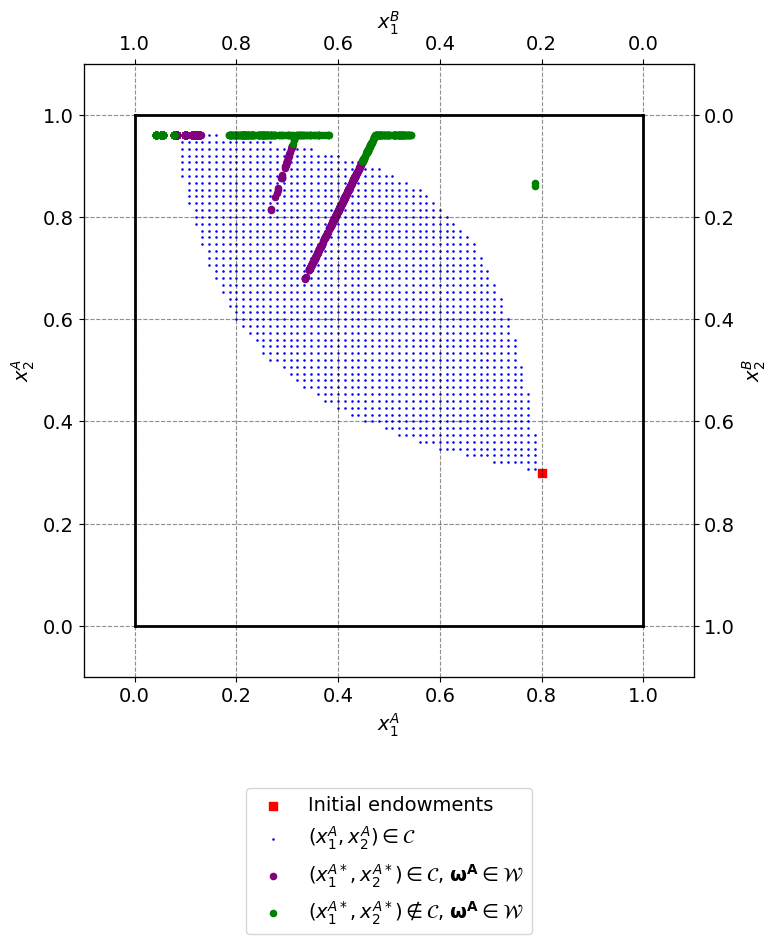

In [17]:
# Plot C
ax_A.scatter(x1as, x2as, marker='o', color='purple', label=r'$(x_1^{A*}, x_2^{A*}) \in \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$', s=20)
ax_A.scatter(x1as_out, x2as_out, marker='o', color='green', label=r'$(x_1^{A*}, x_2^{A*}) \notin \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$', s=20)
legend = ax_A.legend(loc='center', bbox_to_anchor=(.5,-.3))
fig_A